In [1]:
import glob

all_filenames = glob.glob('./dataset/data/names/*.txt')
print(all_filenames)

['./dataset/data/names/German.txt', './dataset/data/names/French.txt', './dataset/data/names/Arabic.txt', './dataset/data/names/English.txt', './dataset/data/names/Russian.txt', './dataset/data/names/Czech.txt', './dataset/data/names/Irish.txt', './dataset/data/names/Dutch.txt', './dataset/data/names/Portuguese.txt', './dataset/data/names/Chinese.txt', './dataset/data/names/Spanish.txt', './dataset/data/names/Italian.txt', './dataset/data/names/Vietnamese.txt', './dataset/data/names/Polish.txt', './dataset/data/names/Japanese.txt', './dataset/data/names/Korean.txt', './dataset/data/names/Scottish.txt', './dataset/data/names/Greek.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
import torch

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [7]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


In [85]:
from torch import nn
from torch.autograd import Variable

class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(input_size, hidden_size)
        self.dense = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        out, hidden = self.rnn(input, hidden)
        out = self.dense(out)
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)


n_hidden = 128
rnn = MyRNN(n_letters, n_hidden, n_categories)

In [12]:
# rnn = nn.RNN(10, 20, 1)
# input = torch.randn(5, 3, 10)
# h0 = torch.randn(1, 3, 20)
# output, hn = rnn(input, h0)
# print(output.size(), hn.size())

torch.Size([5, 3, 20]) torch.Size([1, 3, 20])


In [86]:
input = line_to_tensor('Albert')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0:3], hidden)
print('output.size =', output.size())
print(output)

output.size = torch.Size([3, 1, 18])
tensor([[[ 0.1400,  0.0178, -0.0476,  0.0719, -0.0116, -0.0920,  0.2236,
           0.1338, -0.0644, -0.0694,  0.0075, -0.0884,  0.0153, -0.0216,
           0.0151,  0.1304,  0.1218, -0.0011]],

        [[ 0.0779,  0.0171, -0.0523,  0.1218, -0.0924, -0.0108,  0.1505,
           0.1429, -0.0406, -0.0097,  0.0121, -0.0414,  0.0566, -0.0391,
          -0.0071,  0.1823,  0.1290,  0.0354]],

        [[ 0.1158,  0.0723, -0.0761,  0.0773, -0.0976, -0.0492,  0.1917,
           0.1708,  0.0035, -0.0063,  0.0650, -0.0210,  0.0127, -0.0541,
          -0.0420,  0.1340,  0.1822,  0.0248]]], grad_fn=<AddBackward0>)


In [87]:
input = line_to_tensor('Albert')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0:1], hidden)
output, next_hidden = rnn(input[1:2], next_hidden)
output, next_hidden = rnn(input[2:3], next_hidden)
print('output.size =', output.size())
print(output)

output.size = torch.Size([1, 1, 18])
tensor([[[ 0.1158,  0.0723, -0.0761,  0.0773, -0.0976, -0.0492,  0.1917,
           0.1708,  0.0035, -0.0063,  0.0650, -0.0210,  0.0127, -0.0541,
          -0.0420,  0.1340,  0.1822,  0.0248]]], grad_fn=<AddBackward0>)


In [88]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i
print(category_from_output(output))

('Irish', tensor([6]))


In [89]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Czech / line = Stangl
category = Italian / line = Tamaro
category = Italian / line = Roma
category = German / line = Schroder
category = Portuguese / line = Pereira
category = Dutch / line = Rutten
category = Italian / line = Acciai
category = Korean / line = Chin
category = Japanese / line = Isoda
category = Irish / line = O'Keefe


In [90]:
criterion = nn.CrossEntropyLoss()

In [91]:
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [92]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    # output, hidden = rnn(line_tensor, hidden)
    # loss = criterion(output[-1], category_tensor)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i:i+1], hidden)
    loss = criterion(output[0], category_tensor)
    
    loss.backward()
    
    optimizer.step()
    
    return output, loss.item()

In [96]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 0.7899 Harry / English ✓
10000 10% (0m 14s) 1.7793 Mas / Chinese ✗ (German)
15000 15% (0m 21s) 0.0008 Takeuchi / Japanese ✓
20000 20% (0m 28s) 0.0208 Ngo / Vietnamese ✓
25000 25% (0m 35s) 0.0028 Hayashida / Japanese ✓
30000 30% (0m 42s) 1.0757 Kauffmann / Russian ✗ (German)
35000 35% (0m 49s) 4.1398 Schwangau / French ✗ (German)
40000 40% (0m 57s) 0.0006 Polymenakou / Greek ✓
45000 45% (1m 4s) 0.0039 Bellandini / Italian ✓
50000 50% (1m 11s) 0.0051 Gorecki / Polish ✓
55000 55% (1m 18s) 0.7802 Thibault / French ✓
60000 60% (1m 25s) 0.0684 Hrula / Czech ✓
65000 65% (1m 32s) 0.2889 Tos / Spanish ✓
70000 70% (1m 39s) 0.0108 Roncalli / Italian ✓
75000 75% (1m 47s) 0.2903 Rana / Italian ✓
80000 80% (1m 54s) 0.0199 D'cruze / Portuguese ✓
85000 85% (2m 1s) 0.0014 Nahas / Arabic ✓
90000 90% (2m 8s) 0.5213 Bohn / German ✓
95000 95% (2m 15s) 0.7215 Furst / German ✓
100000 100% (2m 22s) 0.0011 Taflambas / Greek ✓


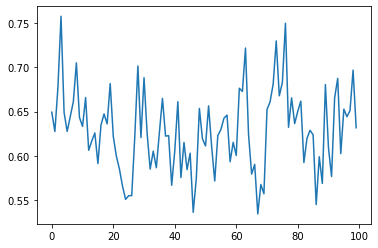

In [97]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

<ipython-input-99-e1fa74c8586d>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-99-e1fa74c8586d>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


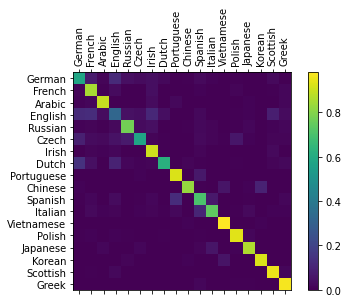

In [99]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i:i+1], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()